# Image Processing Project : Anatomically Constrained Neural Network (ACNN) Segmentation - Camus Dataset

*Made by **Evan Blaszczyk** **Gatien Darley** and **Tianrui Huang** from the INSA Lyon, France.*

*This notebook has been written on the basis of an other notebook implementing a UNet made by **Hang Jung Ling** and **Olivier Bernard** from the INSA Lyon, France.*

*This project is based on this [article](https://arxiv.org/abs/1705.08302) written by **Ozan Oktay** presenting ACNN.

As shown on this image, the purpose of ACNN is to firstly train an auto-encoder on CAMUS dataset labels and reuse its encoder part as a function to express those same labels and their prediction coming from the UNet to compute a second loss (MSE) to update the UNet parameters.

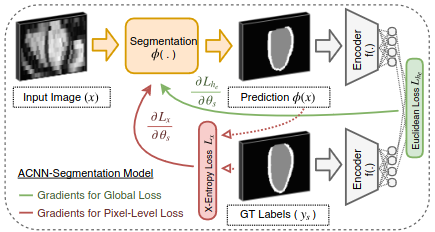

This notebook shows how to train, test and evaluate a ACNN to segment different cardiac structures on [CAMUS dataset](https://humanheart-project.creatis.insa-lyon.fr/database/#collection/6373703d73e9f0047faa1bc8).

CAMUS is one of the largest public echocardiogaphic datasets, with 500 patients and each patient has 4 echocardiographic images: end-diastolic (ED) and end-systolic (ES) frames acquired in both apical two chamber and apical four chamber views. Each image is annotated by an expert and contains 3 classes + background:</br>
&emsp;1) Left ventricle</br>
&emsp;2) Myocardium</br>
&emsp;3) Left atrium</br>

Summary :</br>
&emsp;I.   [Install dependencies](#install)</br>
&emsp;II.  [Dataset](#dataset)</br>
&emsp;III.  [Train](#train)</br>
&emsp;IV. [Tests and results](#visualize)</br>


# I. Install dependencies <a class="anchor" id="install"></a>

Kindly ignore this step if you have installed your own environment using `environment.yaml`. If not, please execute the following cells to install the dependencies.

In [ ]:
%%capture project_path_setup

import sys

if "../" in sys.path:
    print(sys.path)
else:
    sys.path.append("../")
    print(sys.path)

In [ ]:
%%capture packages_install

# Make sure the repo's package and its dependencies are installed
%pip install -e ../.

# II. Dataset <a class="anchor" id="dataset"></a>

Once the environment is successfully setup, download the CAMUS dataset by executing the following cell. The dataset will be downloaded to the `data/` folder. 

In [ ]:
from pathlib import Path

from tqdm.auto import tqdm

# Make sure the data is downloaded and extracted where it should be
if not Path("../data/camus_64").is_dir():
    import zipfile
    from io import BytesIO
    from urllib.request import urlopen

    zipurl = "https://www.creatis.insa-lyon.fr/~bernard/camus/camus_64.zip"
    with urlopen(zipurl) as zipresp:
        with zipfile.ZipFile(BytesIO(zipresp.read())) as zfile:
            for member in tqdm(
                zfile.infolist(), desc="Downloading and extracting data", position=0, leave=True
            ):
                try:
                    zfile.extract(member, "../data/")
                except zipfile.error as e:
                    pass

Now, let's split these data into training, validation and testing sets. We will use 80% of the data for training, 10% for validation and 10% for testing. The split is done by patient ID, so that the same patient will not appear in different sets.

In [ ]:
from pathlib import Path

from sklearn.model_selection import train_test_split

from src.utils.file_and_folder_operations import subdirs

# Specify the data directory
data_dir = Path("../data/camus_64").resolve()

# List all the patients id
keys = subdirs(data_dir, prefix="patient", join=False)

# Split the patients into 80/10/10 train/val/test sets
train_keys, val_and_test_keys = train_test_split(keys, train_size=0.8, random_state=12345)
val_keys, test_keys = train_test_split(val_and_test_keys, test_size=0.5, random_state=12345)

train_keys = sorted(train_keys)
val_keys = sorted(val_keys)
test_keys = sorted(test_keys)

# Create train, val and test datalist
viws_instants = ["2CH_ED", "2CH_ES", "4CH_ED", "4CH_ES"]
train_datalist = [
    {
        "image": str(data_dir / key / f"{key}_{view}.nii.gz"),
        "label": str(data_dir / key / f"{key}_{view}_gt.nii.gz"),
    }
    for key in train_keys
    for view in viws_instants
]

val_datalist = [
    {
        "image": str(data_dir / key / f"{key}_{view}.nii.gz"),
        "label": str(data_dir / key / f"{key}_{view}_gt.nii.gz"),
    }
    for key in val_keys
    for view in viws_instants
]

test_datalist = [
    {
        "image": str(data_dir / key / f"{key}_{view}.nii.gz"),
        "label": str(data_dir / key / f"{key}_{view}_gt.nii.gz"),
    }
    for key in test_keys
    for view in viws_instants
]

print("Example of train keys: ", train_datalist[:2])
print("Example of validation keys: ", val_datalist[:2])
print("Example of test keys: ", test_datalist[:2])

Once the data is split, we will create a `Dataset` object for each set. This object will be used to load the data during training and testing.

In [ ]:
import numpy as np
from monai.data import CacheDataset
from monai.transforms import (
    Compose,
    EnsureChannelFirstd,
    LoadImaged,
    NormalizeIntensityd,
    RandAdjustContrastd,
    RandFlipd,
    RandGaussianNoised,
    RandGaussianSmoothd,
    RandRotated,
    RandScaleIntensityd,
    RandZoomd,
)

# Transforms to load data
load_transforms = [
    LoadImaged(keys=["image", "label"], image_only=True),  # Load image and label
    EnsureChannelFirstd(
        keys=["image", "label"]
    ),  # Make sure the first dimension is the channel dimension
    NormalizeIntensityd(keys=["image"]),  # Normalize the intensity of the image
]

# Transforms to augment data
range_x = [-15.0 / 180 * np.pi, 15.0 / 180 * np.pi]
data_augmentation_transforms = [
    RandRotated(
        keys=["image", "label"],
        range_x=range_x,
        range_y=0,
        range_z=0,
        mode=["bicubic", "nearest"],
        padding_mode="zeros",
        prob=0.2,
    ),
    RandZoomd(
        keys=["image", "label"],
        min_zoom=0.7,
        max_zoom=1.4,
        mode=["bicubic", "nearest"],
        padding_mode="constant",
        align_corners=(True, None),
        prob=0.2,
    ),
    RandGaussianNoised(keys=["image"], std=0.01, prob=0.15),
    RandGaussianSmoothd(
        keys=["image"],
        sigma_x=(0.5, 1.15),
        sigma_y=(0.5, 1.15),
        prob=0.15,
    ),
    RandScaleIntensityd(keys=["image"], factors=0.3, prob=0.15),
    RandAdjustContrastd(keys=["image"], gamma=(0.7, 1.5), prob=0.3),
    RandFlipd(keys=["image", "label"], spatial_axis=[0], prob=0.5),
]

# Define transforms for training, validation and testing
train_transforms = Compose(load_transforms + data_augmentation_transforms)
val_transforms = Compose(load_transforms)
test_transforms = Compose(load_transforms)

# Use CacheDataset to accelerate training and validation
train_ds = CacheDataset(data=train_datalist, transform=train_transforms, cache_rate=1.0)
val_ds = CacheDataset(data=val_datalist, transform=val_transforms, cache_rate=1.0)
test_ds = CacheDataset(data=test_datalist, transform=test_transforms, cache_rate=1.0)

Now, let's visualize some images from the training set. The images are displayed with their corresponding ground truth segmentation masks.

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

from src.utils.visualizations import imagesc

# Get a random index to display the image with label from each dataset
train_idx = np.random.randint(len(train_ds))
val_idx = np.random.randint(len(val_ds))
test_idx = np.random.randint(len(test_ds))

# Print the selected indices
print("train_idx: ", train_idx)
print("val_idx: ", val_idx)
print("test_idx: ", test_idx)

# Visualize a random image with label from each dataset
colors = ["black", "red", "green", "blue"]
cmap = ListedColormap(colors)

figure = plt.figure(figsize=(8, 8))
train_sample = train_ds[train_idx]
image = train_sample["image"].detach().cpu().numpy()[0].transpose(1, 0)
label = train_sample["label"].detach().cpu().numpy()[0].transpose(1, 0)
ax = figure.add_subplot(3, 2, 1)
imagesc(ax, image, title="Training image", show_colorbar=False)
ax = figure.add_subplot(3, 2, 2)
imagesc(
    ax, label, title="Training label", show_colorbar=False, colormap=cmap, interpolation="nearest"
)

val_sample = val_ds[val_idx]
image = val_sample["image"].detach().cpu().numpy()[0].transpose(1, 0)
label = val_sample["label"].detach().cpu().numpy()[0].transpose(1, 0)
ax = figure.add_subplot(3, 2, 3)
imagesc(ax, image, title="Validation image", show_colorbar=False)
ax = figure.add_subplot(3, 2, 4)
imagesc(
    ax,
    label,
    title="Validation label",
    show_colorbar=False,
    colormap=cmap,
    interpolation="nearest",
)

test_sample = test_ds[test_idx]
image = test_sample["image"].detach().cpu().numpy()[0].transpose(1, 0)
label = test_sample["label"].detach().cpu().numpy()[0].transpose(1, 0)
ax = figure.add_subplot(3, 2, 5)
imagesc(ax, image, title="Test image", show_colorbar=False)
ax = figure.add_subplot(3, 2, 6)
imagesc(ax, label, title="Test label", show_colorbar=False, colormap=cmap, interpolation="nearest")
figure.tight_layout()
plt.show()

# III. Train <a class="anchor" id="train"></a>
Let's move on to train a ACNN to segment the left ventricle, myocardium and left atrium. We will use the training and validation sets created in the previous section.

### Definition of ACNN architecture (segmentation network = UNet)

In [ ]:
from torchinfo import summary

from src.models.unet import UNet

input_channels = 1  # This is the number of input channels in the image
input_shape = (input_channels, 64, 64)  # This is the shape of the input image to the network
num_classes = 4  # This is the number of output classes
output_shape = (num_classes, 64, 64)  # This is the shape of the output mask
init_channels = 32  # This is the number of channels in the first layer of the network

acnn = UNet(input_shape=input_shape, output_shape=output_shape, init_channels=init_channels)

# Print the summary of the network
summary_kwargs = dict(
    col_names=["input_size", "output_size", "kernel_size", "num_params"], depth=3, verbose=0
)
summary(acnn, (1, *input_shape), device="cpu", **summary_kwargs)

### Import whole auto-encoder and get implement its encoder part as a function

In [ ]:
import torch
from src.models.autoencoder import *

# Determine the device to run the model on
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

input_channel = 4  # This is the number of input channels in the image
output_channel = 1  # This is the number of output channel
init_channel = 64  # This is the output channel's number of input convolution
compress_channel = 1  # This is the channel's number of compress convolution at the end of bottleneck

ae_conv = AE_Conv(input_channel, output_channel, init_channel, compress_channel)
encoder = Encoder(input_channel, init_channel, compress_channel)

ae_conv = torch.load("../logs/ae_second_step/best_metric_model_16.pth", map_location=device) #CHECK THAT THE AUTO-ENCODER MODEL NAME IS THE WANTED ONE

#Load the 4 first layers parameters of auto-encoder into encoder
encoder.inc.load_state_dict(ae_conv.inc.state_dict())
encoder.down1.load_state_dict(ae_conv.down1.state_dict())
encoder.down2.load_state_dict(ae_conv.down2.state_dict())
encoder.down3.load_state_dict(ae_conv.down3.state_dict())
encoder.down4.load_state_dict(ae_conv.down4.state_dict())
encoder.compress.load_state_dict(ae_conv.compress.state_dict())

#Lock encoder parameters
for param in encoder.parameters():
    param.requires_grad = False

### Definition of optimizer and loss function
We will use the Adam optimizer. The loss function is the combination of the Dice and cross-entropy (CE) loss, which is a standard loss function for segmentation tasks.
> **&#9432;** The exact computation of the loss function is CE - Dice, which means its minimum value is -1 instead of 0 in the best case scenario.

In [ ]:
from functools import partial

from torch.nn import MSELoss

from src.utils.loss_functions.dice_loss import DC_and_CE_loss

# Soft dice and CE loss function
loss_function = DC_and_CE_loss(
    {"batch_dice": True, "smooth": 1e-5, "do_bg": False}, weight_ce=1, weight_dice=1
)

# MSE loss function for comparison between ref (=label) and prediction in the auto-encoder latent space
loss_function_latent = MSELoss();

# Adam optimizer
optimizer = partial(torch.optim.Adam, params=acnn.parameters())

### Definition of training function

In [ ]:
import os
import time
from typing import Union

import torch.nn.functional as F
from monai.data import DataLoader
from torch import nn
from torch.utils.data import Dataset
from tqdm.auto import tqdm

from src.utils.tensor_utils import sum_tensor
from src.utils.conversion_4ch import ConversionTo4Channels


def train_process(
    train_ds: Dataset,
    val_ds: Dataset,
    num_workers: int,
    model: nn.Module,
    encoder: nn.Module,
    loss_function: nn.Module,
    loss_function_latent: nn.Module,
    optimizer: torch.optim.Optimizer,
    num_classes: int,
    batch_size: int = 2,
    lr: float = 0.001,
    max_epochs: int = 100,
    weight_MSE: float = 1.0,
    log_dir: Union[Path, str] = Path("../logs/camus_segmentation"),
    val_interval=1,
) -> tuple[float, list[float], list[float], list[float], list[float], list[float], list[float], list[int], list[float]]:
    """Trains a neural network model for segmentation on the provided datasets using the specified parameters.

    Args:
        train_ds: Training dataset.
        val_ds: Validation dataset.
        num_workers: Number of workers to use for data loading.
        model: Neural network model.
        loss_function: Loss function.
        optimizer: Optimizer.
        num_classes: Number of classes to segment.
        batch_size: Number of batch size. Defaults to 2.
        lr: Learning rate. Defaults to 0.001.
        max_epochs: Maximum training epochs. Defaults to 30.
        weight_MSE: Weight (=influence) of MSE loss in global loss
        log_dir: Path to the logging directory. Defaults to Path("../logs/camus_segmentation").
        val_interval: Epoch interval to perform evaluation steps. Defaults to 1.

    Returns:
        - Total time taken for training.
        - List containing training loss values for each epoch.
        - List containing training segmentation loss values (DC and CE) for each epoch.
        - List containing training latent loss values (MSE) for each epoch.
        - List containing validation loss values for each evaluation epoch.
        - List containing validation segmentation loss values (DC and CE) for each epoch.
        - List containing validation latent loss values (MSE) for each epoch.
        - List containing epochs where validation is performed.
        - List containing metric values for each evaluation epoch.
    """
    # Create train and validation dataloaders
    train_dataloader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=torch.cuda.is_available(),
    )
    val_dataloader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=torch.cuda.is_available(),
    )

    # Determine the device to run the model on
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"GPU detected, training on: {device}!\n")
    else:
        device = torch.device("cpu")
        print("GPU not detected, training on CPU!\n")

    # Move the models to the device
    model = model.to(device)
    encoder = encoder.to(device)

    # Finalize the creation of the optimizer object with the learning rate
    optimizer = optimizer(lr=lr)

    # Convert log directory to Path object if needed
    if not isinstance(log_dir, Path):
        log_dir = Path(log_dir)
    # Create the log directory if it does not exist
    log_dir.mkdir(parents=True, exist_ok=True)

    # Define some variables to keep track of the best metric values, epoch time and losses
    best_metric = -1
    best_metric_epoch = -1
    epoch_train_loss_values = []
    epoch_train_loss_segm_values = []
    epoch_train_loss_latent_values = []
    epoch_val_loss_values = []
    epoch_val_loss_segm_values = []
    epoch_val_loss_latent_values = []
    metric_values = []
    epoch_val = []
    metric_per_class = {f"metric/{i}": [] for i in range(1, num_classes)}
    total_start = time.time()

    #Define MSE loss weight and normalization
    weight_norm_MSE = 0.02*weight_MSE
    
    fit_pbar = tqdm(range(max_epochs), desc="Training", unit="epoch", position=0, leave=True)
    pbar_metrics = {"train/loss": None, "val/loss": None, "val/dice": None}

    for epoch in fit_pbar:
        model.train()
        epoch_loss = 0
        epoch_loss_segm = 0
        epoch_loss_latent = 0
        epoch_val_loss = 0
        epoch_val_loss_segm = 0
        epoch_val_loss_latent = 0
        step = 0
        epoch_tp_hard = []
        epoch_fp_hard = []
        epoch_fn_hard = []
        for batch_data in train_dataloader:
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )
            labels_4ch = ConversionTo4Channels(labels).to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            
            #We pass the prediction and the label into the encoder
            outputs_latent = encoder(outputs) #encode segmented image into latent space
            labels_latent = encoder(labels_4ch) #encode labels (=reference) into latent space
            
            #We compute both losses
            loss_segm = loss_function(outputs, labels)
            loss_latent = loss_function_latent(outputs_latent, labels_latent) #compute MSE loss in the latent space
            loss = loss_segm + weight_norm_MSE*loss_latent #weighted sum of both losses
            
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_loss_segm += loss_segm.item()
            epoch_loss_latent += loss_latent.item()
            pbar_metrics["loss"] = loss.item()
            pbar_metrics["train_batch"] = f"{step}/{len(train_dataloader)}"
            fit_pbar.set_postfix(pbar_metrics)

        epoch_loss /= step
        epoch_loss_segm /= step
        epoch_loss_latent *= weight_norm_MSE/step
        epoch_train_loss_values.append(epoch_loss)
        epoch_train_loss_segm_values.append(epoch_loss_segm)
        epoch_train_loss_latent_values.append(epoch_loss_latent)
        pbar_metrics["train/loss"] = epoch_loss
        pbar_metrics.pop("loss")
        pbar_metrics.pop("train_batch")
        fit_pbar.set_postfix(pbar_metrics)

        if (epoch + 1) % val_interval == 0:
            step = 0
            model.eval()
            with torch.no_grad():
                for val_data in val_dataloader:
                    step += 1
                    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )
                    val_labels_4ch = ConversionTo4Channels(val_labels).to(device)
                    val_outputs = model(val_inputs)
                    
                    #We pass the prediction and the label into the encoder without computing the gradient
                    val_outputs_latent = encoder(val_outputs) #encode segmented image into latent space
                    val_labels_latent = encoder(val_labels_4ch) #encode labels (=reference) into latent space

                    #We compute both losses
                    val_loss_segm = loss_function(val_outputs, val_labels)
                    val_loss_latent = loss_function_latent(val_outputs_latent, val_labels_latent) #compute MSE loss in the latent space
                    val_loss = val_loss_segm + weight_norm_MSE*val_loss_latent #weighted sum of both losses
                    
                    epoch_val_loss += val_loss.item()
                    epoch_val_loss_segm += val_loss_segm.item()
                    epoch_val_loss_latent += val_loss_latent.item()
                    pbar_metrics["loss"] = val_loss.item()
                    pbar_metrics["val_batch"] = f"{step}/{len(val_dataloader)}"
                    fit_pbar.set_postfix(pbar_metrics)

                    # Compute tp, fp, and fn that will be used to compute the hard dice metric per epoch
                    val_labels = val_labels[:, 0]
                    axes = tuple(range(1, len(val_labels.shape)))
                    # Convert the output logits to a segmentation mask
                    val_outputs = F.softmax(val_outputs, dim=1).argmax(dim=1)

                    tp_hard = torch.zeros((val_labels.shape[0], num_classes - 1)).to(
                        val_outputs.device.index
                    )
                    fp_hard = torch.zeros((val_labels.shape[0], num_classes - 1)).to(
                        val_outputs.device.index
                    )
                    fn_hard = torch.zeros((val_labels.shape[0], num_classes - 1)).to(
                        val_outputs.device.index
                    )

                    for c in range(1, num_classes):
                        tp_hard[:, c - 1] = sum_tensor(
                            (val_outputs == c).float() * (val_labels == c).float(), axes=axes
                        )
                        fp_hard[:, c - 1] = sum_tensor(
                            (val_outputs == c).float() * (val_labels != c).float(), axes=axes
                        )
                        fn_hard[:, c - 1] = sum_tensor(
                            (val_outputs != c).float() * (val_labels == c).float(), axes=axes
                        )

                    tp_hard = tp_hard.sum(0, keepdim=False).detach().cpu().numpy()
                    fp_hard = fp_hard.sum(0, keepdim=False).detach().cpu().numpy()
                    fn_hard = fn_hard.sum(0, keepdim=False).detach().cpu().numpy()

                    # Store the tp_hard, fp_hard, and fn_hard per evaluation step
                    epoch_tp_hard.append(list(tp_hard))
                    epoch_fp_hard.append(list(fp_hard))
                    epoch_fn_hard.append(list(fn_hard))

                epoch_val_loss /= step
                epoch_val_loss_segm /= step
                epoch_val_loss_latent *= weight_norm_MSE/step
                epoch_val_loss_values.append(epoch_val_loss)
                epoch_val_loss_segm_values.append(epoch_val_loss_segm)
                epoch_val_loss_latent_values.append(epoch_val_loss_latent)
                epoch_val.append(epoch + 1)
                pbar_metrics.pop("loss")
                pbar_metrics.pop("val_batch")
                pbar_metrics["val/loss"] = float(epoch_val_loss)

                # Compute the hard dice metric per epoch
                epoch_tp_hard = np.sum(epoch_tp_hard, 0)
                epoch_fp_hard = np.sum(epoch_fp_hard, 0)
                epoch_fn_hard = np.sum(epoch_fn_hard, 0)

                # Compute the hard dice metric per class
                global_dc_per_class = [
                    i if not np.isnan(i) else 0.0
                    for i in [
                        2 * i / (2 * i + j + k)
                        for i, j, k in zip(epoch_tp_hard, epoch_fp_hard, epoch_fn_hard)
                    ]
                ]

                val_metric = np.mean(global_dc_per_class)
                metric_values.append(val_metric)
                pbar_metrics["val/dice"] = val_metric
                for i in range(1, num_classes, 1):
                    pbar_metrics[f"val/dice/{i}"] = global_dc_per_class[i - 1]
                    metric_per_class[f"metric/{i}"].append(global_dc_per_class[i - 1])
                fit_pbar.set_postfix(pbar_metrics)

                if val_metric > best_metric:
                    best_metric = val_metric
                    best_metric_epoch = epoch + 1
                    # Save best metric model checkpoint
                    torch.save(
                        {
                            "max_epochs": max_epochs,
                            "current_epoch": epoch + 1,
                            "best_metric_epoch": best_metric_epoch,
                            "train_loss": epoch_train_loss_values,
                            "val_loss": epoch_val_loss_values,
                            "epoch_val": epoch_val,
                            "metric_values": metric_values,
                            "metric_per_class": metric_per_class,
                            "model_state_dict": model.state_dict(),
                            "optimizer_state_dict": optimizer.state_dict(),
                        },
                        str(log_dir / "best_metric_model.pth"),
                    )

        # Save last model checkpoint
        torch.save(
            {
                "max_epochs": max_epochs,
                "current_epoch": epoch + 1,
                "best_metric_epoch": best_metric_epoch,
                "train_loss": epoch_train_loss_values,
                "val_loss": epoch_val_loss_values,
                "epoch_val": epoch_val,
                "metric_values": metric_values,
                "metric_per_class": metric_per_class,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
            },
            str(log_dir / "last_model.pth"),
        )

    print(
        f"train completed, best_metric: {best_metric:.4f}"
        f" at epoch: {best_metric_epoch}"
        f" total time: {(time.time() - total_start):.4f}"
    )
    return (
        time.time() - total_start,
        epoch_train_loss_values,
        epoch_train_loss_segm_values,
        epoch_train_loss_latent_values,
        epoch_val_loss_values,
        epoch_val_loss_segm_values,
        epoch_val_loss_latent_values,
        epoch_val,
        metric_values,
        metric_per_class,
    )

### Definition of training hyperparameters
In this section, we will define the hyperparameters for training, such as the number of epochs, the learning rate, the batch size, etc.
IF YOU WANT TO TEST PRETRAINED MODEL WITHOUT TRAINING A NEW ONE, GO DIRECTLY TO &emsp;IV. [Tests and results](#visualize)</br>

In [ ]:
batch_size = 2  # Number of batch size
lr = 0.001  # Learning rate
max_epochs = 50  # Number of epochs to train the model
weight_MSE = 0.5
num_workers = os.cpu_count() - 1  # Number of workers to use for data loading

# Train the model
(
    total_time,
    epoch_train_loss_values,
    epoch_train_loss_segm_values,
    epoch_train_loss_latent_values,
    epoch_val_loss_values,
    epoch_val_loss_segm_values,
    epoch_val_loss_latent_values,
    epoch_val,
    metric_values,
    metric_per_class,
) = train_process(
    train_ds=train_ds,
    val_ds=val_ds,
    num_workers=num_workers,
    model=acnn,
    encoder=encoder,
    loss_function=loss_function,
    loss_function_latent=loss_function_latent,
    optimizer=optimizer,
    num_classes=num_classes,
    batch_size=batch_size,
    lr=lr,
    max_epochs=max_epochs,
    weight_MSE = weight_MSE,
    log_dir="../logs/camus_segmentation",
)

### Plot training losses, validation losses and validation dice over epochs

In [ ]:
from matplotlib.ticker import MaxNLocator

trains_epoch = list(range(1, max_epochs + 1, 1))
vals_epochs = epoch_val
plt.figure("train", (16, 8))

ax = plt.subplot(2, 3, 1)
plt.title("Epoch Average Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Set integer ticks for x-axis
plt.plot(trains_epoch, epoch_train_loss_values, color="red", label="Train")
plt.plot(vals_epochs, epoch_val_loss_values, color="blue", label="Val")
plt.legend(loc="upper right")

ax = plt.subplot(2, 3, 2)
plt.title("Epoch Average weighted DC and CE Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Set integer ticks for x-axis
plt.plot(trains_epoch, epoch_train_loss_segm_values, color="red", label="Train")
plt.plot(vals_epochs, epoch_val_loss_segm_values, color="blue", label="Val")
plt.legend(loc="upper right")

ax = plt.subplot(2, 3, 3)
plt.title("Epoch Average weighted MSE Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Set integer ticks for x-axis
plt.plot(trains_epoch, epoch_train_loss_latent_values, color="red", label="Train")
plt.plot(vals_epochs, epoch_val_loss_latent_values, color="blue", label="Val")
plt.legend(loc="upper right")

ax = plt.subplot(2, 3, 4)
plt.title("Val Mean Dice")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Set integer ticks for x-axis
plt.plot(vals_epochs, metric_values, color="green")

ax = plt.subplot(2, 3, 5)
plt.title("Val Mean Dice per Class")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Set integer ticks for x-axis
legend_metric = ["left ventricle", "myocardium", "left atrium"]
for i in range(1, num_classes, 1):
    plt.plot(vals_epochs, metric_per_class[f"metric/{i}"], label=legend_metric[i - 1])
plt.legend(loc="upper left")
plt.show()

# IV. Tests and results <a class="anchor" id="visualize"></a>

### Import a pre-trained ACNN model weights and visualize learning curves and metrics

In [ ]:
from matplotlib.ticker import MaxNLocator

# Path to the logging directory
log_dir = "../logs/camus_segmentation" #PUT THE MODELS .pth IN THIS DIRECTORY

# Determine the device to run the model on
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Load the best model weight
best_model = Path(log_dir) / "best_model_0_5-100ep.pth" #CHECK THAT THE ACNN PRETRAINED MODEL NAME IS THE WANTED ONE

# Load the weight
weight = torch.load(best_model, map_location=device)
epoch_train_loss_values = weight["train_loss"]
epoch_val_loss_values = weight["val_loss"]
epoch_val = weight["epoch_val"]
metric_values = weight["metric_values"]
metric_per_class = weight["metric_per_class"]
max_epochs = weight["max_epochs"]
best_metric_epoch = weight["best_metric_epoch"]

# Plot the training losses, validation losses and validation dice over epochs
trains_epoch = epoch_val
vals_epochs = epoch_val

plt.figure("train", (16, 8))
ax = plt.subplot(1, 3, 1)
plt.title("Epoch Average Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Set integer ticks for x-axis
plt.plot(trains_epoch, epoch_train_loss_values, color="red", label="Train")
plt.plot(vals_epochs, epoch_val_loss_values, color="blue", label="Val")
# Add a vertical line at the best model epoch
plt.axvline(best_metric_epoch, color="gray", linestyle="--")
plt.text(
    best_metric_epoch + 0.5,
    min(epoch_train_loss_values) * 4 / 5,
    f"Best model epoch = {best_metric_epoch}",
    rotation=90,
)
plt.legend(loc="upper right")
ax = plt.subplot(1, 3, 2)
plt.title("Val Mean Dice")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Set integer ticks for x-axis
plt.plot(vals_epochs, metric_values, color="green")
plt.axvline(best_metric_epoch, color="gray", linestyle="--")

ax = plt.subplot(1, 3, 3)
plt.title("Val Mean Dice per Class")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Set integer ticks for x-axis
legend_metric = ["left ventricle", "myocardium", "left atrium"]
for i in range(1, num_classes, 1):
    plt.plot(vals_epochs, metric_per_class[f"metric/{i}"], label=legend_metric[i - 1])
plt.axvline(best_metric_epoch, color="gray", linestyle="--")
plt.legend(loc="upper left")
plt.show()

### Download a pre-trained UNet model weights and visualize learning curves and metrics

In [ ]:
# Load the best model weight
model_unet = Path(log_dir) / "best_model_50epochs.pth"
if not model_unet.is_file():
    import urllib.request

    urllib.request.urlretrieve(
        "https://www.creatis.insa-lyon.fr/~bernard/camus/best_model_50epochs.pth",
        str(model_unet),
    )

# Load the weight
weight_unet = torch.load(model_unet, map_location=device)
epoch_train_loss_values = weight_unet["train_loss"]
epoch_val_loss_values = weight_unet["val_loss"]
epoch_val = weight_unet["epoch_val"]
metric_values = weight_unet["metric_values"]
metric_per_class = weight_unet["metric_per_class"]
max_epochs = weight_unet["max_epochs"]
best_metric_epoch = weight_unet["best_metric_epoch"]

# Plot the training losses, validation losses and validation dice over epochs
trains_epoch = list(range(1, max_epochs + 1, 1))
vals_epochs = epoch_val

plt.figure("train", (16, 8))
ax = plt.subplot(1, 3, 1)
plt.title("Epoch Average Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Set integer ticks for x-axis
plt.plot(trains_epoch, epoch_train_loss_values, color="red", label="Train")
plt.plot(vals_epochs, epoch_val_loss_values, color="blue", label="Val")
# Add a vertical line at the best model epoch
plt.axvline(best_metric_epoch, color="gray", linestyle="--")
plt.text(
    best_metric_epoch + 0.5,
    min(epoch_train_loss_values) * 4 / 5,
    f"Best model epoch = {best_metric_epoch}",
    rotation=90,
)
plt.legend(loc="upper right")
ax = plt.subplot(1, 3, 2)
plt.title("Val Mean Dice")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Set integer ticks for x-axis
plt.plot(vals_epochs, metric_values, color="green")
plt.axvline(best_metric_epoch, color="gray", linestyle="--")

ax = plt.subplot(1, 3, 3)
plt.title("Val Mean Dice per Class")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Set integer ticks for x-axis
legend_metric = ["left ventricle", "myocardium", "left atrium"]
for i in range(1, num_classes, 1):
    plt.plot(vals_epochs, metric_per_class[f"metric/{i}"], label=legend_metric[i - 1])
plt.axvline(best_metric_epoch, color="gray", linestyle="--")
plt.legend(loc="upper left")
plt.show()

### Load the pre-trained model weights into the ACNN and import a UNet for comparison on inference

In [ ]:
# Set to True to use the pretrained model
# Set to False to use the model you just trained
log_dir="../logs/camus_segmentation"
use_pretrained = True

if use_pretrained:
    weight = torch.load(Path(log_dir) / "best_model_0_5-100ep.pth", map_location=device)
else:
    weight = torch.load(Path(log_dir) / "best_metric_model.pth", map_location=device)

# Load the weight into the ACNN
acnn.load_state_dict(weight["model_state_dict"])
# Move the ACNN to the correct device
acnn.to(device)
# Put the ACNN in evaluation mode
acnn.eval()

###Import the UNet
unet = UNet(input_shape=input_shape, output_shape=output_shape, init_channels=init_channels)
# Load the weight into the ACNN
unet.load_state_dict(weight_unet["model_state_dict"])
# Move the ACNN to the correct device
unet.to(device)
# Put the ACNN in evaluation mode
unet.eval()

### Perform the inference on the test set
First, we create the dataloader from the test dataset we defined at the beginning.

In [ ]:
# Create the test dataloader
num_workers = os.cpu_count() - 1

test_dataloader = DataLoader(
    test_ds,
    batch_size=1,
    num_workers=num_workers,
    pin_memory=torch.cuda.is_available(),
)

# Create an iterator to iterate over the test dataloader
test_dataloader_iter = iter(test_dataloader)

Then, we perform the inference on a sample from the test dataset and plot the prediction.

In [ ]:
# Run inference on a test image
batch_data = next(test_dataloader_iter)
with torch.no_grad():
    image = batch_data["image"].to(device)
    pred = acnn(image)
    pred = F.softmax(pred, dim=1).argmax(dim=1)
    pred = pred.squeeze().detach().cpu().numpy().transpose(1, 0)
    pred_unet = unet(image)
    pred_unet = F.softmax(pred_unet, dim=1).argmax(dim=1)
    pred_unet = pred_unet.squeeze().detach().cpu().numpy().transpose(1, 0)
    label = batch_data["label"].squeeze().detach().cpu().numpy().transpose(1, 0)
    image = image.squeeze().detach().cpu().numpy().transpose(1, 0)

# Plot the image, label and prediction
figure = plt.figure(figsize=(8, 8))
ax = figure.add_subplot(1, 4, 1)
imagesc(ax, image, title="Image", show_colorbar=False)
ax = figure.add_subplot(1, 4, 2)
imagesc(ax, label, title="Label", show_colorbar=False, colormap=cmap, interpolation="nearest")
ax = figure.add_subplot(1, 4, 3)
imagesc(ax, pred_unet, title="Prediction UNet", show_colorbar=False, colormap=cmap, interpolation="nearest")
ax = figure.add_subplot(1, 4, 4)
imagesc(ax, pred, title="Prediction ACNN", show_colorbar=False, colormap=cmap, interpolation="nearest")
figure.tight_layout()
plt.show()

### Testing the performances of the model

In [ ]:
from scipy import ndimage
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torch.nn import MSELoss
from scipy import ndimage
from scipy.spatial.distance import directed_hausdorff
from torchmetrics.functional.classification import dice
from statistics import mean
from statistics import stdev

# MODEL TO ADAPT WITH THE NETWORK TESTED :  
#Unet --> "best_model_50epochs.pth"
#acnn loss weight = 0.5 --> "0_5-100ep.pth"
#acnn loss weight = 0.1 --> "0_1-100ep.pth" 
#acnn loss weight = 1 --> "1-100ep.pth" 

test_accuracy_list = []
test_ssim_list = []
test_region_list = []

test_hausdorff_class_1_list = []
test_hausdorff_class_2_list = []
test_hausdorff_class_3_list = []

test_dice_class_1_list = []
test_dice_class_2_list = []
test_dice_class_3_list = []

test_step = 0
max_acc = 0.0
min_acc = 100.0
max_ssim = 0.0
min_ssim = 1.0
pb_nb = 0
nb_aberrant_reg_class_1 = 0
nb_aberrant_reg_class_2 = 0
nb_aberrant_reg_class_3 = 0
max_acc_sample = None
min_acc_sample = None
max_ssim_sample = None
min_ssim_sample = None

with torch.no_grad():
    for test_batch_data in test_dataloader:
        test_step += 1
        region_nb = 0
        nb_reg_class_1 = 0
        nb_reg_class_2 = 0
        nb_reg_class_3 = 0
        acnn.eval()
        acnn.to(device)
        
        label = test_batch_data["label"].squeeze().detach().cpu().numpy().transpose(1, 0)
        test_inputs = test_batch_data["image"].to(device)
        
        
        test_outputs = acnn(test_inputs)
        test_outputs = F.softmax(test_outputs, dim=1).argmax(dim=1)
        test_outputs = test_outputs.squeeze().detach().cpu().numpy().transpose(1, 0)
        test_inputs = test_inputs.squeeze().detach().cpu().numpy().transpose(1, 0)
        
        label_class_1 = label*(label == 1).astype(int)
        label_class_2= label*(label == 2).astype(int)
        label_class_3 = label*(label == 3).astype(int)
        
        test_outputs_1 = test_outputs*(test_outputs == 1).astype(int)
        test_outputs_2= test_outputs*(test_outputs == 2).astype(int)
        test_outputs_3 = test_outputs*(test_outputs == 3).astype(int)
        
        '''
        #accuracy calculation for test dataset
        test_inputs_tensor = test_batch_data["image"].to(device)
        test_outputs_tensor = model(test_inputs_tensor)
        test_correct_pixel = torch.sum(torch.eq(test_inputs_tensor, test_outputs_tensor)).item()
        test_total_pixel = test_inputs_tensor.numel()
        test_acc = (test_correct_pixel / test_total_pixel) * 100
        test_accuracy_list.append(test_acc)
        '''
        
        # Dice calculation per class
        #https://www.kaggle.com/code/yerramvarun/understanding-dice-coefficient
        #https://lightning.ai/docs/torchmetrics/stable/classification/dice.html
        test_outputs_1_tensor = torch.tensor(test_outputs_1)#convert into tensor
        test_outputs_2_tensor = torch.tensor(test_outputs_2)
        test_outputs_3_tensor = torch.tensor(test_outputs_3)
        label_class_1_tensor = torch.tensor(label_class_1)
        label_class_2_tensor = torch.tensor(label_class_2)
        label_class_3_tensor = torch.tensor(label_class_3)
        
        dice_class_1 = dice(label_class_1_tensor, test_outputs_1_tensor==1)
        dice_class_2 = dice(label_class_2_tensor, test_outputs_2_tensor==2)
        dice_class_3 = dice(label_class_3_tensor, test_outputs_3_tensor==3) 
        
        dice_value_class_1 = dice_class_1.item()
        dice_value_class_2 = dice_class_2.item()
        dice_value_class_3 = dice_class_3.item() 
        
        test_dice_class_1_list.append(dice_value_class_1)
        test_dice_class_2_list.append(dice_value_class_2)
        test_dice_class_3_list.append(dice_value_class_3)
        
        
        # Hausdorff distance calculation per strutur (i.e. per class)
        hausdorff_dist_class_1_pix = max(directed_hausdorff(label_class_1, test_outputs_1), directed_hausdorff(test_outputs_1, label_class_1))
        hausdorff_dist_class_2_pix= max(directed_hausdorff(label_class_2, test_outputs_2), directed_hausdorff(test_outputs_2, label_class_2))
        hausdorff_dist_class_3_pix = max(directed_hausdorff(label_class_3, test_outputs_3), directed_hausdorff(test_outputs_3, label_class_3))
        
        test_hausdorff_class_1_list.append(hausdorff_dist_class_1_pix[0])
        test_hausdorff_class_2_list.append(hausdorff_dist_class_2_pix[0])
        test_hausdorff_class_3_list.append(hausdorff_dist_class_3_pix[0])
        
        
        # shape problems detection for the 3 structurs      
        reg_mask_class_1, nb_reg_class_1 = ndimage.label(test_outputs_1)
        reg_mask_class_2, nb_reg_class_2 = ndimage.label(test_outputs_2)
        reg_mask_class_3, nb_reg_class_3 = ndimage.label(test_outputs_3)
        
        nb_aberrant_reg_class_1 += (nb_reg_class_1 - 1)
        nb_aberrant_reg_class_2 += (nb_reg_class_2 - 1)
        nb_aberrant_reg_class_3 += (nb_reg_class_3 - 1)

        region_nb = nb_reg_class_1 + nb_reg_class_2 + nb_reg_class_3
        
        test_region_list.append(region_nb)
        
        if region_nb != 3 :
            pb_nb += 1

    
# Results for the model
# average hausdorff distance per class
average_hausdorff_dist_class_1 = mean(test_hausdorff_class_1_list)
average_hausdorff_dist_class_2 = mean(test_hausdorff_class_2_list)
average_hausdorff_dist_class_3 = mean(test_hausdorff_class_3_list)

stdev_hausdorff_dist_class_1 = stdev(test_hausdorff_class_1_list)
stdev_hausdorff_dist_class_2 = stdev(test_hausdorff_class_2_list)
stdev_hausdorff_dist_class_3 = stdev(test_hausdorff_class_3_list)

# average dice per class
average_dice_class_1 = mean(test_dice_class_1_list)
average_dice_class_2 = mean(test_dice_class_2_list)
average_dice_class_3 = mean(test_dice_class_3_list)

stdev_dice_class_1 = stdev(test_dice_class_1_list)
stdev_dice_class_2 = stdev(test_dice_class_2_list)
stdev_dice_class_3 = stdev(test_dice_class_3_list)
 
# fail rate of the model used
model_fail_rate = pb_nb/len(test_dataloader.dataset)

# Printing of the results
print(f"\033[1mDice results \033[0m")
print("Average dice for class 1 = ", average_dice_class_1)
print("Average dice for class 2 = ", average_dice_class_2)
print("Average dice for class 3 = ", average_dice_class_3, end ="\n\n")

print("Standard deviation for dice for class 1 = ", stdev_dice_class_1)
print("Standard deviation for dice for class 2 = ", stdev_dice_class_2)
print("Standard deviation for dice for class 3 = ", stdev_dice_class_3, end ="\n\n")

print(f"\033[1mHausdorff distance results \033[0m")
print("Average hausdorff distance for class 1 = ", average_hausdorff_dist_class_1)
print("Average hausdorff distance for class 2 = ", average_hausdorff_dist_class_2)
print("Average hausdorff distance for class 3 = ", average_hausdorff_dist_class_3, end ="\n\n")

print("Standard deviation for Hausdorff distance for class 1 = ", stdev_hausdorff_dist_class_1)
print("Standard deviation for Hausdorff distance for class 2 = ", stdev_hausdorff_dist_class_2)
print("Standard deviation for Hausdorff distance for class 3 = ", stdev_hausdorff_dist_class_3, end ="\n\n")

print(f"\033[1mAberrant regions results \033[0m")
print("Number of aberrant regions for class 1 : ", nb_aberrant_reg_class_1)
print("Number of aberrant regions for class 2 : ", nb_aberrant_reg_class_2)
print("Number of aberrant regions for class 3 : ", nb_aberrant_reg_class_3, end ="\n\n")


print("Number of segmentations with aberrant regions (in the meaning of simply related regions) : ", pb_nb)

print("Fail rate of the model used (in the meaning of simply related regions) : ", model_fail_rate)
